In [1]:
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import re
import string
import spacy
import os
import os.path as osp
from tqdm import tqdm
import time

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# nltl
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Gensim libraries
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Symspellpy
from symspellpy.symspellpy import SymSpell, Verbosity

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pouriadaneshvar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pouriadaneshvar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pouriadaneshvar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pouriadaneshvar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data Loading

In [2]:
PATH = Path('./data//IMDB Dataset.csv')
reviews_df = pd.read_csv(PATH)

reviews_df.head(n=5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
reviews_df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# Preprocessing

In [4]:
def initialize_symspell(dictionary_path):
    """Initializes SymSpell with the given dictionary."""
    sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    return sym_spell

def basic_preprocessing(text):
    """Preprocesses text: lowercasing, removing HTML, URLs, and tokenizing."""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    words = nltk.word_tokenize(text)  # Tokenization BEFORE punctuation removal
    return words

def spell_correction(words, sym_spell):
    """Performs spelling correction using SymSpell."""
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)
    return corrected_words

def remove_stopwords(words, stop_words):
    """Removes stopwords from a list of words."""
    return [word for word in words if word not in stop_words]

def remove_punctuation(words):
    """Removes punctuation from words."""
    return [word for word in words if word not in string.punctuation]

def stemming(words):
    """Applies stemming to words."""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatization(words):
    """Applies lemmatization to words."""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def full_pipeline(text, sym_spell, stop_words, spell_check=False, use_stemming=False, use_lemmatization=False):
    """Runs full preprocessing pipeline with options to enable/disable steps."""
    words = basic_preprocessing(text)  # Lowercase, HTML & URL removal, tokenization
    words = remove_punctuation(words)  # Punctuation removal
    words = remove_stopwords(words, stop_words)  # Stopword removal
    if use_stemming:
        words = stemming(words)  # Stemming
    if use_lemmatization:
        words = lemmatization(words)  # Lemmatization
    if spell_check:
        words = spell_correction(words, sym_spell)  # Spell correction
    return ' '.join(words)

def process_dataframe(df, column, sym_spell, stop_words, spell_check=False, use_stemming=False, use_lemmatization=False):
    """Applies text preprocessing to the specified column of a DataFrame with a progress bar."""
    tqdm.pandas(desc="Processing reviews")
    df[column + "_cleaned"] = df[column].progress_apply(lambda text: full_pipeline(
        text, sym_spell, stop_words, spell_check, use_stemming, use_lemmatization
    ))
    return df

sym_spell = initialize_symspell("./data/frequency_dictionary_en_82_765.txt")
stop_words = set(stopwords.words('english'))

cleaned_pth = "./data/IMDB Cleaned.csv"
if osp.exists(cleaned_pth):
    reviews_df = pd.read_csv(cleaned_pth)
else:
    reviews_df = process_dataframe(reviews_df, "review", sym_spell, stop_words, True, False, True)
    reviews_df.to_csv("./data/IMDB Cleaned.csv", index=False)

In [26]:
for text in reviews_df.review_cleaned.head(n=5):
    print(text.split())


['one', 'reviewer', 'mentioned', 'watching', 'a', 'of', 'episode', 'all', 'hooked', 'right', 'exactly', 'happened', 'metre', 'first', 'thing', 'struck', 'of', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word.it', 'called', 'of', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentiary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'pm', 'city', 'home', 'many', 'of', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', '....', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'would', 'not', 'dare', 'forget', 'pretty', 'picture', 'painted', 'mainstream', 'audie

# Train Test Split

In [5]:
reviews_df["label"] = reviews_df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

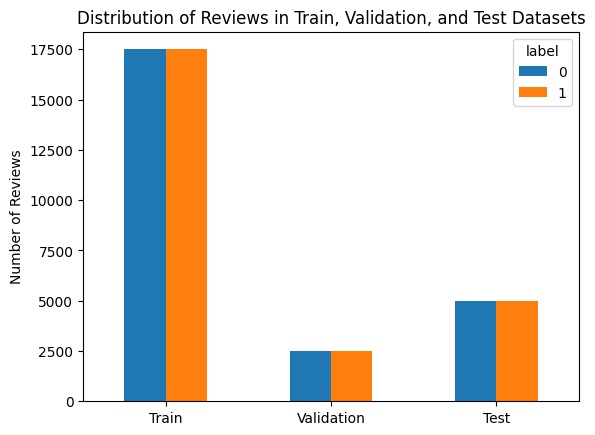

In [6]:
train_size = 0.7
val_size = 0.1
test_size = 0.2

train_val_df, test_df = train_test_split(
    reviews_df, test_size=test_size, random_state=42, stratify=reviews_df["label"]
)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size / (train_size + val_size),
    random_state=42,
    stratify=train_val_df["label"],
)

# plot the distribution of the labels in all the datasets
count_df = pd.DataFrame(
    {
        "train": train_df["label"].value_counts(normalize=False),
        "val": val_df["label"].value_counts(normalize=False),
        "test": test_df["label"].value_counts(normalize=False),
    }
).sort_index()
count_df = count_df.T

fig, ax = plt.subplots()
count_df.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Train", "Validation", "Test"], rotation=0)
ax.set_ylabel("Number of Reviews")
ax.set_title("Distribution of Reviews in Train, Validation, and Test Datasets")
plt.show()

# Feature Extraction

In [7]:
bcv = CountVectorizer(binary=True, lowercase=False, stop_words=None, max_features=5000)
X_train_bcv = bcv.fit_transform(train_df["review_cleaned"])
X_val_bcv = bcv.transform(val_df["review_cleaned"])
X_test_bcv = bcv.transform(test_df["review_cleaned"])
y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

# Train ML Model

In [8]:
import time


def timeit(method):
    """Decorator to time a function and print the first argument (model)."""

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        model_name = args[0].__repr__() if args else "UnknownModel"
        print(
            f"{method.__name__} [{model_name}] with data of shape {args[1].shape} took: {te - ts} sec"
        )
        return result

    return timed


@timeit
def train_model(model, X, y):
    """Trains a model and evaluates it on the validation set."""
    model.fit(X, y)
    return model


@timeit
def test_model(model, X, y):
    """Evaluates a model on the test set."""
    preds = model.predict(X)
    return preds

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
import time

# SVC
svc = LinearSVC(random_state=42)
print("Training:")
svc = train_model(svc, X_train_bcv, y_train)

print("\nResults:")
print("Train set:")
p_train_svc = test_model(svc, X_train_bcv, y_train)
print(classification_report(y_train, p_train_svc))

print("Validation set:")
p_val_svc = test_model(svc, X_val_bcv, y_val)
print(classification_report(y_val, p_val_svc))

print("Test set:")
p_test_svc = test_model(svc, X_test_bcv, y_test)
print(classification_report(y_test, p_test_svc))

Training:
train_model [LinearSVC(random_state=42)] with data of shape (34999, 5000) took: 1.484314203262329 sec

Results:
Train set:
test_model [LinearSVC(random_state=42)] with data of shape (34999, 5000) took: 0.006964921951293945 sec
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17499
           1       0.94      0.94      0.94     17500

    accuracy                           0.94     34999
   macro avg       0.94      0.94      0.94     34999
weighted avg       0.94      0.94      0.94     34999

Validation set:
test_model [LinearSVC(random_state=42)] with data of shape (5001, 5000) took: 0.001766204833984375 sec
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2501
           1       0.86      0.85      0.85      2500

    accuracy                           0.85      5001
   macro avg       0.85      0.85      0.85      5001
weighted avg       0.85      0.85      0.85  

In [20]:
log_reg = LogisticRegression(random_state=42)
print("Training:")
log_reg = train_model(log_reg, X_train_bcv, y_train)

print("\nResults:")
print("Train set:")
p_train_log_reg = test_model(log_reg, X_train_bcv, y_train)
print(classification_report(y_train, p_train_log_reg))

print("Validation set:")
p_val_log_reg = test_model(log_reg, X_val_bcv, y_val)
print(classification_report(y_val, p_val_log_reg))

print("Test set:")
p_test_log_reg = test_model(log_reg, X_test_bcv, y_test)
print(classification_report(y_test, p_test_log_reg))

Training:
train_model [LogisticRegression(random_state=42)] with data of shape (34999, 5000) took: 0.6208043098449707 sec

Results:
Train set:
test_model [LogisticRegression(random_state=42)] with data of shape (34999, 5000) took: 0.006288051605224609 sec
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     17499
           1       0.93      0.94      0.94     17500

    accuracy                           0.94     34999
   macro avg       0.94      0.94      0.94     34999
weighted avg       0.94      0.94      0.94     34999

Validation set:
test_model [LogisticRegression(random_state=42)] with data of shape (5001, 5000) took: 0.001026153564453125 sec
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2501
           1       0.87      0.87      0.87      2500

    accuracy                           0.87      5001
   macro avg       0.87      0.87      0.87      5001
weighted avg     